<a href="https://colab.research.google.com/github/rant95/Advanced-artificial-intelligence/blob/main/Projet_cyclegan_VanGogh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet RCP211: Traduction d’image avec le modèle CycleGAN
CNAM 

Année 2021/2022 - semestre 2

Dataset: Van Gogh + Natural_images

Lova Rantoanison

# Introduction
Bonjour à tous, bienvenue dans ce noyau. Dans ce noyau, je vais générer de nouveaux tableaux de Van Gogh en utilisant le jeu de données des tableaux de Van Gogh et le jeu de données des images naturelles.

Avant de commencer, jetons un coup d'oeil au contenu de ce noyau

# Sommaire
1. Importation des bibliothèques nécessaires
1. Chargement des données
1. Construction du modèle de générateur
1. Modèle de discriminateur de bâtiment
1. Construction du modèle CycleGAN
1. Définition des optimiseurs et des fonctions de perte
1. Modèle d'entraînement
1. Génération de quelques tableaux


 Ce notebook a ete adapté suivant l'article de Jun-Yan Zhu et le code de junyanz.

- [Article](https://arxiv.org/pdf/1703.10593.pdf)
- [Implémentation originale](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

# Importer les bibliothèques nécessaires
Dans cette section, je vais importer les bibliothèques que je vais utiliser.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GAN/Vangogh

/content/drive/MyDrive/GAN/Vangogh


In [ ]:
#from google.colab import files

#uploaded = files.upload()

#for fn in uploaded.keys():
 # print('User uploaded file "{name}" with length {length} bytes'.format(
  #    name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
#!kaggle datasets download -d prasunroy/natural-images
#!kaggle datasets download -d ipythonx/van-gogh-paintings

100% 341M/342M [00:03<00:00, 124MB/s]
100% 342M/342M [00:03<00:00, 96.5MB/s]


In [ ]:
%cd /content/drive/MyDrive/GAN/Vangogh/van-gogh-paintings

/content/drive/MyDrive/GAN/Vangogh/van-gogh-paintings


In [ ]:
%cd /content/drive/MyDrive/GAN/Vangogh/

/content/drive/MyDrive/GAN/Vangogh


In [ ]:
#!unzip van-gogh-paintings.zip
#!unzip natural-images.zip

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

import cv2 
from glob import glob
import os

In [ ]:
%cd /content/drive/MyDrive/GAN/Vangogh/
!ls

/content/drive/MyDrive/GAN/Vangogh
data  model.h5	natural-images.zip  van-gogh-paintings


# Chargement du jeu de données
Dans cette section, je vais charger les images.

In [ ]:
main_path = "/content/drive/MyDrive/GAN/Vangogh/van-gogh-paintings"
style_img_paths = []
for class_path in [os.path.join(main_path,class_name) for class_name in os.listdir(main_path)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        style_img_paths.append(class_img_path)

print("There are {} style images in Van Gogh Paintings Dataset".format(len(style_img_paths)))

There are 2025 style images in Van Gogh Paintings Dataset


In [ ]:
main_path = "/content/drive/MyDrive/GAN/Vangogh/data/natural_images"
normal_image_paths = []
for class_path in [os.path.join(main_path,class_name) for class_name in os.listdir(main_path)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        normal_image_paths.append(class_img_path)

print("There are {} natural images in the Natural Images Dataset".format(len(normal_image_paths)))

There are 6007 natural images in the Natural Images Dataset


* Nous avons déterminé les chemins des images, maintenant nous pouvons les lire.

In [ ]:
style_images = []
normal_images = []

for style_path in style_img_paths:
    img = cv2.imread(style_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    style_images.append(img)
    
for normal_path in normal_image_paths:
    img = cv2.imread(normal_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    
print(len(style_images))
print(len(normal_images))

In [ ]:
# converting to float32 
style_images = np.array(style_images,dtype=np.float32)
normal_images = np.array(normal_images,dtype=np.float32)

# scaling between -1 and 1
style_images = style_images / 127.5 - 1
normal_images = normal_images / 127.5 - 1

# batching
style_images = tf.data.Dataset.from_tensor_slices(style_images).batch(1)
normal_images = tf.data.Dataset.from_tensor_slices(normal_images).batch(1)

* Nos images sont prêtes, vérifions-les.





In [ ]:
plt.figure(figsize=(7,7))
plt.title("Style Images")
for i,image in enumerate(style_images.shuffle(10000).take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

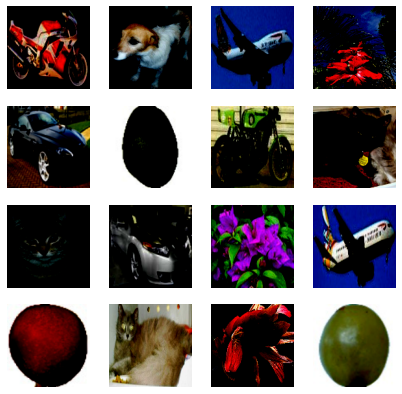

In [ ]:
plt.figure(figsize=(7,7))
plt.title("Natural Images")
for i,image in enumerate(normal_images.shuffle(10000).take(4)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.show()

# Construction du modèle de générateur
Dans cette section, je vais construire les réseaux générateurs du CycleGAN.

In [ ]:
# we need to downsample and upsample the images, so let's write two new layers, Upsample layer and Downsample Layer
OUTPUT_CHANNELS = len(["Red","Green","Blue"])

def downsample(filters,size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    return result



* Grâce à ces couches, nous pouvons facilement créer notre générateur et notre discriminateur.

In [ ]:
# discriminator

def Generator():
    inputs = layers.Input([128,128,3])
    
    down_stack = [downsample(128,4), # 64x64x128
                  downsample(256,4), # 32x32x256
                  downsample(512,4), # 16x16x512
                  downsample(512,4), # 8x8x512
                  downsample(512,4), # 4x4x512
                  downsample(512,4), # 2x2x512
                  downsample(512,4), # 1x1x512
                 ]
    
    up_stack = [upsample(512,4,apply_dropout=True), # 2x2
                upsample(512,4,apply_dropout=True), # 4x4
                upsample(512,4), # 8x8
                upsample(256,4), # 16x16
                upsample(128,4), # 32x32
                upsample(64,4),  # 64x64
               ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    
    # we'll create skip connections like a residual network
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs,outputs=x)

* Générateur est un peu confus, je sais.
1. Tout d'abord, le générateur prend une image 128x128x3 (ce sera notre image naturelle) et la convertit en un vecteur 1x1x512.
1. Ensuite, il suréchantillonne ce vecteur en 128x128x3.
1. Nous avons créé des connexions de saut, elles permettront d'éviter le problème du gradient de fuite.
1. Et enfin, nous avons renvoyé notre modèle.

# Construction du modèle discriminant
Dans cette section, je vais construire le modèle discriminateur. Ce sera plus facile, car Discriminator est un classificateur basé sur CNN. Il détermine si l'image est réelle ou générée.


In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    inp = layers.Input([128,128,3],name="input_image")
    
    x = inp
    
    down1 = downsample(64,4,False)(x) # 64x64x64
    down2 = downsample(128,4,False)(down1) # 32x32x128
    
    zero_pad1 = layers.ZeroPadding2D()(down2)
    
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=inp,outputs=last)

    

* Nos fonctions sont prêtes, nous pouvons maintenant créer nos générateurs et nos discriminateurs.

In [ ]:
vangogh_generator = Generator() # generates van gogh paintings using natural images
photo_generator = Generator() # generates natural images using van gogh paintings

vangogh_discriminator = Discriminator() # determines whether van gogh painting is real or generated
photo_discriminator = Discriminator() # determines whether natural image is real or generated

# Construction du modèle CycleGAN
Dans cette section, je vais construire le modèle CycleGAN en utilisant nos générateurs et nos discriminateurs.

Je vais créer une nouvelle classe en héritant de la classe model.

In [ ]:
class CycleGAN(keras.Model):
    
    def __init__(self,
                 vangogh_generator,
                 photo_generator,
                 vangogh_discriminator,
                 photo_discriminator,
                 lambda_cycle = 10,
                ):
        super(CycleGAN,self).__init__()
        self.v_gen = vangogh_generator
        self.p_gen = photo_generator
        self.v_disc = vangogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    
    def compile(self,
                v_gen_optimizer,
                p_gen_optimizer,
                p_disc_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn,
                v_disc_optimizer
               ):
        super(CycleGAN,self).compile()
        self.v_gen_optimizer = v_gen_optimizer
        self.p_gen_optimizer =  p_gen_optimizer
        self.v_disc_optimizer  = v_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.p_disc_optimizer = p_disc_optimizer
        
    
    def train_step(self,batch_data):
        real_vangogh,real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to vangogh back to photo
            fake_vangogh = self.v_gen(real_photo,training=True)
            cycled_photo = self.p_gen(fake_vangogh,training=True)
            
            # vangogh to photo back to vangogh
            fake_photo = self.p_gen(real_vangogh,training=True)
            cycled_vangogh = self.v_gen(fake_photo,training=True)
            
            # generating itself
            same_photo = self.p_gen(real_photo,training=True)
            same_vangogh = self.v_gen(real_vangogh,training=True)
            
            # checking images using discriminator
            disc_real_vangogh = self.v_disc(real_vangogh,training=True)
            disc_real_photo = self.p_disc(real_photo,training=True)
            
            disc_fake_vangogh = self.v_disc(fake_vangogh,training=True)
            disc_fake_photo = self.p_disc(fake_photo,training=True)
            
            # computing generator loss
            vangogh_gen_loss = self.gen_loss_fn(disc_fake_vangogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # computing total cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_vangogh,cycled_vangogh,self.lambda_cycle) + self.cycle_loss_fn(real_photo,cycled_photo,self.lambda_cycle)
            
            # computing total loss
            total_vangogh_gen_loss = vangogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vangogh, same_vangogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # computing discriminator loss
            vangogh_disc_loss = self.disc_loss_fn(disc_real_vangogh,disc_fake_vangogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo,disc_fake_photo)
            
        
        # calculating gradients of networks
        vangogh_generator_gradients = tape.gradient(total_vangogh_gen_loss,self.v_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        
        vangogh_discriminator_gradients = tape.gradient(vangogh_disc_loss,self.v_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)
        
        self.v_gen_optimizer.apply_gradients(zip(vangogh_generator_gradients,self.v_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        
        self.v_disc_optimizer.apply_gradients(zip(vangogh_discriminator_gradients,
                                                  self.v_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "v_gen_loss": total_vangogh_gen_loss,
            "p_gen_loss": total_photo_gen_loss,
            "v_disc_loss": vangogh_disc_loss,
            "p_disc_loss": photo_disc_loss
        }
        
        

# Définir les optimiseurs et les fonctions de perte
Dans cette section, je vais définir les optimiseurs et les fonctions de perte.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
def discriminator_loss(real,generated):
    
    real_loss = cross_entropy(tf.ones_like(real),real)
    generated_loss = cross_entropy(tf.zeros_like(generated),generated)
    
    total_loss = real_loss + generated_loss
    
    return total_loss * 0.5
    

Dans la perte du discriminateur, nous avons calculé la perte des images réelles et la perte des images générées et nous les avons additionnées.

In [ ]:
def generator_loss(generated):
    
    return cross_entropy(tf.ones_like(generated),generated)


* But when it comes to compute generator loss, we just use generated (fake) images loss.

In [ ]:
def cycle_loss(real_image,cycled_image,LAMBDA):
    
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image,same_image,LAMBDA):
    
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA

In [ ]:
# We'll use Adam optimizer
vangogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

vangogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Formation du modèle
Dans cette section, je vais entraîner notre modèle CycleGAN.

In [ ]:
model = CycleGAN(vangogh_generator=vangogh_generator,
                photo_generator=photo_generator,
                vangogh_discriminator=vangogh_discriminator,
                photo_discriminator=photo_discriminator
                )

model.compile(v_gen_optimizer=vangogh_generator_optimizer,
              p_gen_optimizer=photo_generator_optimizer,
              p_disc_optimizer=photo_discriminator_optimizer,
              v_disc_optimizer=vangogh_discriminator_optimizer,
              gen_loss_fn=generator_loss,
              disc_loss_fn=discriminator_loss,
              cycle_loss_fn=cycle_loss,
              identity_loss_fn=identity_loss
             )



* Nous avons créé notre modèle, ajustons-le pour 25 epochs.

In [ ]:
#if os.path.exists("./model.h5"):
    #model.load_weights("./model.h5")
    #print("Saved weigths loaded")


model.fit(tf.data.Dataset.zip((style_images,normal_images)),
          epochs=10)

model.save_weights("model.h5")

Epoch 1/10
2025/2025 [==============================] - 410s 180ms/step - v_gen_loss: 8.5738 - p_gen_loss: 8.3942 - v_disc_loss: 0.5577 - p_disc_loss: 0.5126
Epoch 2/10
2025/2025 [==============================] - 365s 180ms/step - v_gen_loss: 7.0520 - p_gen_loss: 6.8766 - v_disc_loss: 0.5981 - p_disc_loss: 0.5429
Epoch 3/10
2025/2025 [==============================] - 365s 180ms/step - v_gen_loss: 6.5669 - p_gen_loss: 6.4366 - v_disc_loss: 0.5673 - p_disc_loss: 0.5090
Epoch 4/10
2025/2025 [==============================] - 366s 181ms/step - v_gen_loss: 6.3051 - p_gen_loss: 6.2155 - v_disc_loss: 0.5485 - p_disc_loss: 0.4991
Epoch 5/10
2025/2025 [==============================] - 367s 181ms/step - v_gen_loss: 6.0950 - p_gen_loss: 5.9867 - v_disc_loss: 0.5333 - p_disc_loss: 0.4971
Epoch 6/10
2025/2025 [==============================] - 367s 181ms/step - v_gen_loss: 5.8615 - p_gen_loss: 5.7216 - v_disc_loss: 0.5218 - p_disc_loss: 0.4990
Epoch 7/10
2025/2025 [==============================

* J'ai entraîné 10 epoch, chaque epoch prend 5 minutes.
* Si vous essayez de former 20 epoch, ce sera mieux.

# Génération de quelques peintures
Dans cette section, je vais générer quelques peintures.

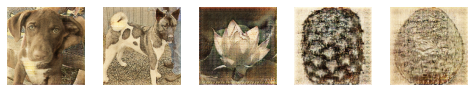

In [ ]:

plt.figure(figsize=(10,10))
for i,image in enumerate(normal_images.shuffle(10000).take(5)):
    plt.subplot(6,6,i+1)
    prediction = vangogh_generator(image,training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(X = prediction)
    plt.axis("off")
    if i==36:
        break
plt.show()

* Notre modèle fonctionne bien, mais il doit s'entraîner davantage.


# Test avec des images

In [ ]:
main_path = "/content/drive/MyDrive/GAN/imag"
normal_image_paths = []
for class_path in [os.path.join(main_path,class_name) for class_name in os.listdir(main_path)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        normal_image_paths.append(class_img_path)

print("There are {} natural images in the Natural Images Dataset".format(len(normal_image_paths)))

There are 25 natural images in the Natural Images Dataset


In [ ]:
print(len(normal_images))
normal_images = []

    
for normal_path in normal_image_paths:
    img = cv2.imread(normal_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    normal_images.append(img)

# converting to float32 

normal_images = np.array(normal_images,dtype=np.float32)

# scaling between -1 and 1

normal_images = normal_images / 127.5 - 1

# batching
normal_images = tf.data.Dataset.from_tensor_slices(normal_images).batch(1)

17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


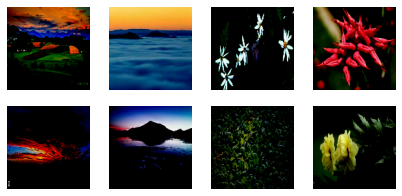

In [ ]:
plt.figure(figsize=(7,7))
plt.title("Images1")
for i,image in enumerate(normal_images.shuffle(10000).take(8)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.show()

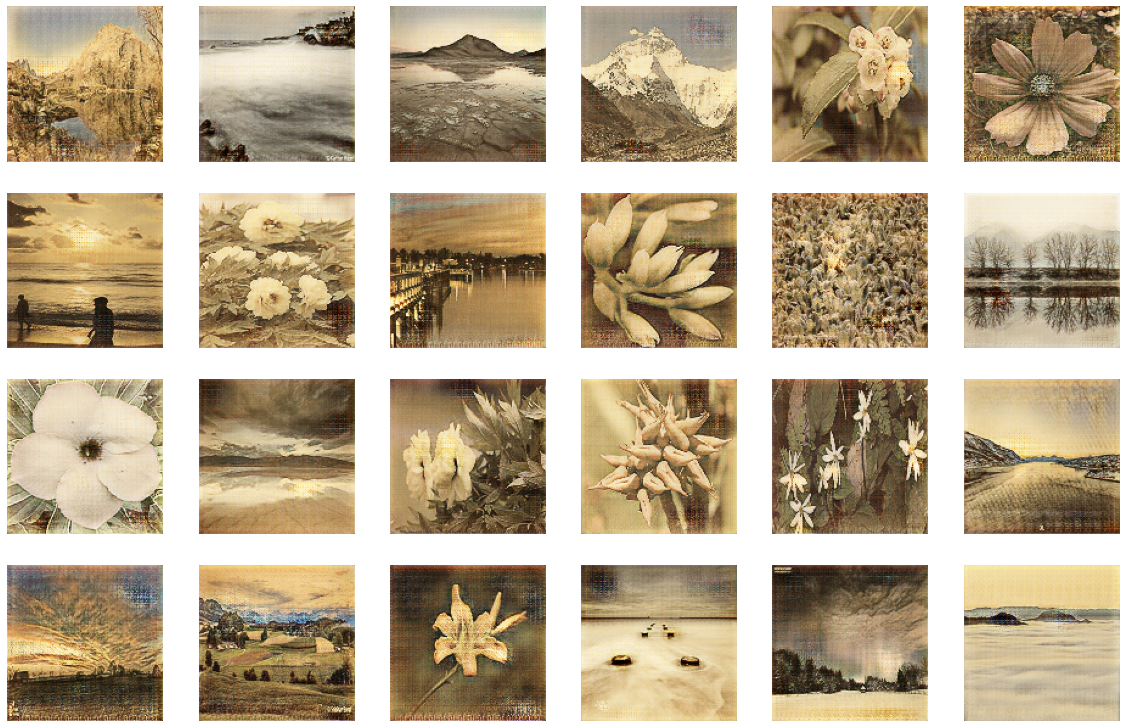

In [ ]:
plt.figure(figsize=(20,20))
for i,image in enumerate(normal_images.shuffle(10000).take(24)):
    plt.subplot(6,6,i+1)
    prediction = vangogh_generator(image,training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(X = prediction)
    plt.axis("off")
    if i==36:
        break
plt.show()